Risa wants to show how cosmology can be degenerate with Cosmology for fixed HOD. I'm gonna make a plot that shows that. 

In [35]:
from pearce.emulator import OriginalRecipe, ExtraCrispy, SpicyBuffalo
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [36]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [37]:
training_file = '/scratch/users/swmclau2/xi_zheng07_cosmo_lowmsat/PearceRedMagicXiCosmoFixedNd.hdf5'
#training_file = '/u/ki/swmclau2/des/PearceRedMagicXiCosmoFixedNdLowMsat.hdf5'
test_file = '/scratch/users/swmclau2/xi_zheng07_cosmo_test_lowmsat/PearceRedMagicXiCosmoFixedNd_Test.hdf5'
#test_file = '/u/ki/swmclau2/des/PearceRedMagicXiCosmoFixedNdLowMsatTest.hdf5'

#test_file = '/u/ki/swmclau2/des/xi_cosmo_tester/PearceRedMagicXiCosmoFixedNd_test.hdf5'
em_method = 'gp'
split_method = 'random'

In [38]:
xi_gm_1 = np.load('xi_gm_vals_1.npy')
xi_gm_2 = np.load('xi_gm_vals_2.npy')

In [39]:
a = 1.0
z = 1.0/a - 1.0

In [40]:
fixed_params = {'z':z}#, 'cosmo': 3}#, 'r':0.53882047}

In [41]:
np.random.seed(0)
emu = SpicyBuffalo(training_file, method = em_method, fixed_params=fixed_params,
                 custom_mean_function = 'linear', downsample_factor = 0.1)

/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:294: UserWarning: WARNING: NaN detected. Skipped 21 points in training data.
  warnings.warn('WARNING: NaN detected. Skipped %d points in training data.' % (num_skipped))


In [42]:
#hod_param_names = ['logM0', 'sigma_logM', 'logM1', 'alpha']
emulation_point = [('logM0', 13.5), ('sigma_logM', 0.25),
                    ('alpha', 0.9),('logM1', 13.5)]#, ('logMmin', 12.233)]

#em_params = {key:test_point_dict[key] for key in hod_param_names}
#em_params = dict(zip(hod_param_names, x_point))
em_params = dict(emulation_point)
em_params.update(fixed_params)

In [43]:
r_bins = np.logspace(-1.1, 1.6, 19)
rpoints = (r_bins[1:]+r_bins[:-1])/2.0

In [44]:
boxno, realization = 0,1

In [45]:
fixed_params = {}#'f_c':1.0}#,'logM1': 13.8 }# 'z':0.0}

cosmo_params = {'simname':'testbox', 'boxno': boxno, 'realization': realization, 'scale_factors':[1.0], 'system': 'sherlock'}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

In [46]:
# get cosmo params
try:
    del em_params['logMmin']
except KeyError:
    pass
cpv = cat._get_cosmo_param_names_vals()

cosmo_param_dict = {key: val for key, val in zip(cpv[0], cpv[1])}

em_params.update( cosmo_param_dict)


In [47]:
y_emu = 10**emu.emulate_wrt_r(em_params)[0]

In [48]:
varied_param_name = 'ln10As'
bounds = emu.get_param_bounds(varied_param_name)
Nvp = 100
vp_vals = np.linspace(bounds[0], bounds[1], Nvp)

varied_param_xis = []
for val in vp_vals:
    em_params[varied_param_name] = val
    varied_param_xis.append(10**emu.emulate_wrt_r(em_params))

In [49]:
vp_palette = sns.cubehelix_palette(Nvp)

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


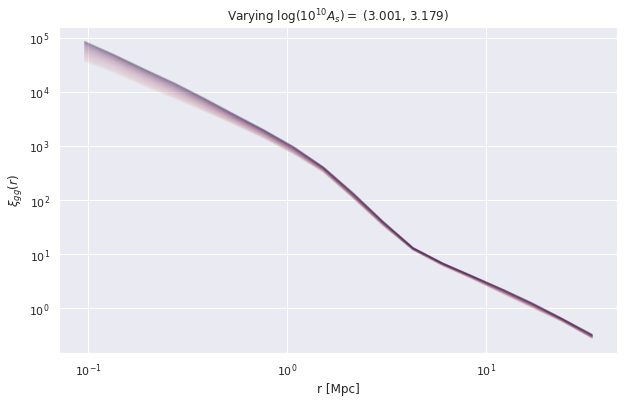

In [50]:
fig = plt.figure(figsize = (10,6))

#for val in chain_vals:
#    plt.plot(rpoints, val[0]-y_calc_jk, c= 'm', alpha = 0.1 )
    
for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
    plt.plot(rpoints, val[0], color = vp_palette[i], alpha = 0.05)
    

#plt.plot(rpoints, MAP_xi, label = 'MAP')
    
#plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')

#plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')
#plt.xscale('log')
plt.loglog()
plt.title(r'Varying $ \log(10^{10} A_s) =$ (%.3f, %.3f)'%bounds)#%varied_param_name)
plt.legend(loc = 'best')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi_{gg}(r)$')
plt.show()

In [51]:
cat.load(1.0, HOD = 'hsabRedMagic')

In [52]:
hod_params = dict(emulation_point)

In [53]:
hod_params['f_c'] = 1.0

In [54]:
from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, cat):
    """
    In the fixed number density case, find the logMmin value that will match the nd given hod_params
    :param: hod_params:
        The other parameters besides logMmin
    :param cat:
        the catalog in question
    :return:
        None. hod_params will have logMmin added to it.
    """
    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params) - 1e-4)**2

    res = minimize_scalar(func, bounds = (12, 16), args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    hod_params['logMmin'] = res.x

In [55]:
add_logMmin(hod_params, cat)

In [56]:
hod_params['mean_occupation_centrals_assembias_param1'] = 0.0
hod_params['mean_occupation_satellites_assembias_param1'] = 0.0

In [57]:
cat.populate(hod_params)

In [58]:
mean_xi = cat.calc_xi(r_bins)

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


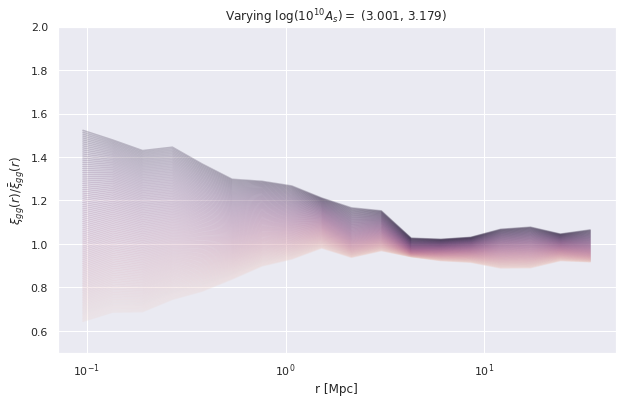

In [59]:
fig = plt.figure(figsize = (10,6))

#for val in chain_vals:
#    plt.plot(rpoints, val[0]-y_calc_jk, c= 'm', alpha = 0.1 )
    
for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
    plt.plot(rpoints, val[0]/mean_xi, color = vp_palette[i], alpha = 0.25)
    

#plt.plot(rpoints, MAP_xi, label = 'MAP')
    
#plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')

#plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')
plt.xscale('log')
#plt.loglog()
plt.title(r'Varying $ \log(10^{10} A_s) =$ (%.3f, %.3f)'%bounds)#%varied_param_name)
plt.legend(loc = 'best')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi_{gg}(r)/\bar{\xi}_{gg}(r)$')
plt.ylim([0.5, 2.0])
plt.show()

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


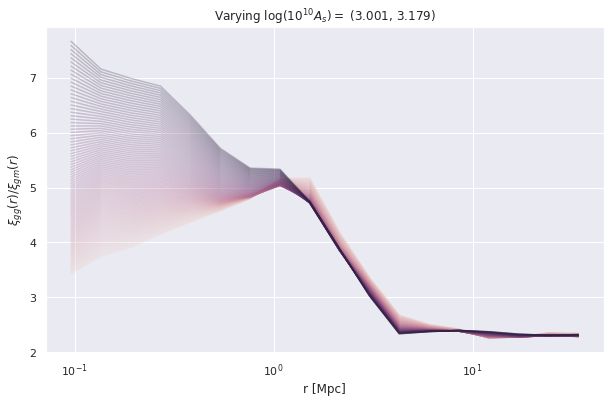

In [60]:
fig = plt.figure(figsize = (10,6))

#for val in chain_vals:
#    plt.plot(rpoints, val[0]-y_calc_jk, c= 'm', alpha = 0.1 )
    
for i, (val, pval, val2) in enumerate(zip(varied_param_xis, vp_vals, xi_gm_1)):
    plt.plot(rpoints, val[0]/val2[0], color = vp_palette[i], alpha = 0.25)
    

#plt.plot(rpoints, MAP_xi, label = 'MAP')
    
#plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')

#plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')
plt.xscale('log')
#plt.loglog()
plt.title(r'Varying $ \log(10^{10} A_s) =$ (%.3f, %.3f)'%bounds)#%varied_param_name)
plt.legend(loc = 'best')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi_{gg}(r)/\xi_{gm}(r)$')
#plt.ylim([0.5, 2.0])
plt.show()

In [61]:
varied_param_name = 'mean_occupation_satellites_assembias_param1'
bounds = (-1, 1)
Nvp = 11
vp_vals = np.linspace(bounds[0], bounds[1], Nvp)

varied_param_xis = []
for val in vp_vals:
    hod_params[varied_param_name] = val
    cat.populate(hod_params)
    varied_param_xis.append(cat.calc_xi(r_bins))

In [62]:
vp_palette = sns.cubehelix_palette(Nvp, start = 50)

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


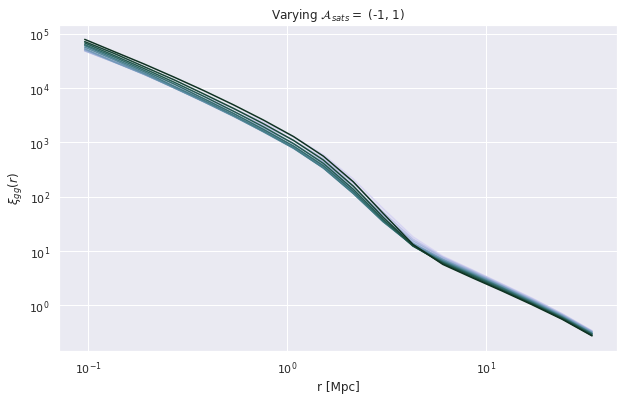

In [63]:
fig = plt.figure(figsize = (10,6))

#for val in chain_vals:
#    plt.plot(rpoints, val[0]-y_calc_jk, c= 'm', alpha = 0.1 )
    
for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
    plt.plot(rpoints, val, color = vp_palette[i], alpha = 1.0)
    

#plt.plot(rpoints, MAP_xi, label = 'MAP')
    
#plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')

#plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')
#plt.xscale('log')
plt.loglog()
plt.title(r'Varying $\mathcal{A}_{sats} = $ (-1, 1)')#%varied_param_name)
plt.legend(loc = 'best')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi_{gg}(r)$')
plt.show()

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


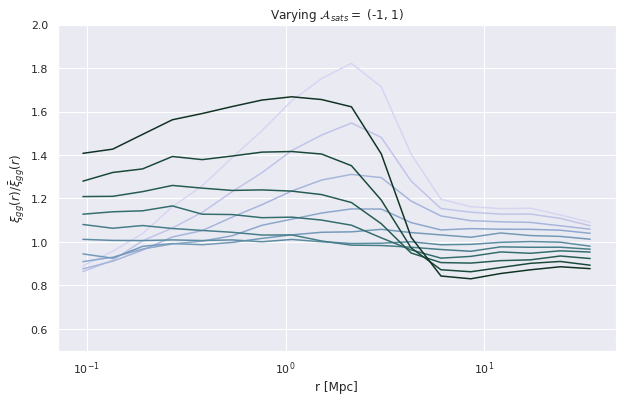

In [64]:
fig = plt.figure(figsize = (10,6))

#for val in chain_vals:
#    plt.plot(rpoints, val[0]-y_calc_jk, c= 'm', alpha = 0.1 )
    
for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
    plt.plot(rpoints, val/mean_xi, color = vp_palette[i], alpha = 1.0)
    

#plt.plot(rpoints, MAP_xi, label = 'MAP')
    
#plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')

#plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')
plt.xscale('log')
#plt.loglog()
plt.title(r'Varying $\mathcal{A}_{sats} = $ (-1, 1)')#%varied_param_name)
plt.legend(loc = 'best')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi_{gg}(r)/\bar{\xi}_{gg}(r)$')
plt.ylim([0.5, 2.0])
plt.show()

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


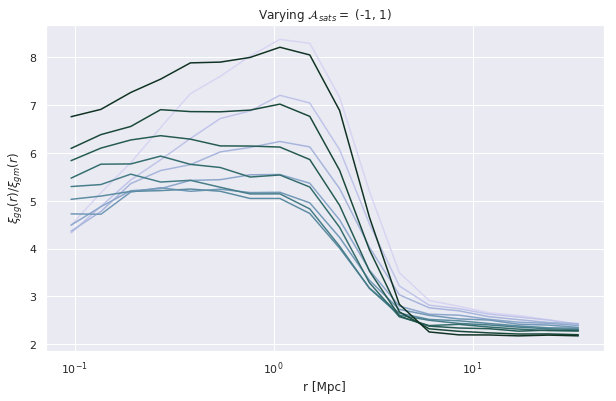

In [65]:
fig = plt.figure(figsize = (10,6))

#for val in chain_vals:
#    plt.plot(rpoints, val[0]-y_calc_jk, c= 'm', alpha = 0.1 )
    
for i, (val, pval, val2) in enumerate(zip(varied_param_xis, vp_vals, xi_gm_2)):
    plt.plot(rpoints, val/val2, color = vp_palette[i], alpha = 1.0)
    

#plt.plot(rpoints, MAP_xi, label = 'MAP')
    
#plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')

#plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')
plt.xscale('log')
#plt.loglog()
plt.title(r'Varying $\mathcal{A}_{sats} = $ (-1, 1)')#%varied_param_name)
plt.legend(loc = 'best')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi_{gg}(r)/\xi_{gm}(r)$')
#plt.ylim([0.5, 2.0])
plt.show()